# Extracting protein sequences' features using ProtBert pretrained-model

## 1. Load necessary libraries including huggingface transformers

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 


In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import numpy as np

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D
from keras.regularizers import l2
from keras.models import Model

## 2. Load the vocabulary and ProtBert Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

In [ ]:
model = TFBertModel.from_pretrained("Rostlab/prot_bert", from_pt=True)

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

## 3. Create or load sequences and map rarely occured amino acids (U,Z,O,B) to (X)

In [ ]:
!git clone https://github.com/33220311/Extremophiles
datasetFolderPath = '/content/Extremophiles/'
trainFilePath = os.path.join(datasetFolderPath, 'linTrainTrunc.csv')
testFilePath = os.path.join(datasetFolderPath, 'Test.csv')

Cloning into 'Extremophiles'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 66 (delta 4), reused 0 (delta 0), pack-reused 54
Unpacking objects: 100% (66/66), done.


In [ ]:
 df = pd.read_csv(trainFilePath,names=['sequence','label'],skiprows=1)
 df_test = pd.read_csv(testFilePath,names=['seq','label'],skiprows=1)

In [ ]:
df.shape

(2213, 2)

In [ ]:
sequences = list(df['sequence'])
test_sequences = list(df_test['seq'])

In [ ]:
sequences = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences]

In [ ]:
test_sequences = [re.sub(r"[UZOB]", "X", seq) for seq in test_sequences]

## 4. Tokenize, encode sequences and load it into the GPU if possibile

In [ ]:
ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True, return_tensors="tf")
test_ids = tokenizer.batch_encode_plus(test_sequences, add_special_tokens=True, padding=True, return_tensors="tf")

In [ ]:
input_ids = ids['input_ids']
attention_mask = ids['attention_mask']

test_input_ids = test_ids['input_ids']
test_attention_mask = test_ids['attention_mask']

In [ ]:
embedding = model(input_ids)[0]
test_embedding = model(test_input_ids)[0]

In [ ]:
embedding = np.asarray(embedding)
test_embedding = np.asarray(test_embedding)

In [ ]:
embedding.shape

(2213, 3, 1024)

In [ ]:
len(embedding)

2213

In [ ]:
attention_mask = np.asarray(attention_mask)
test_attention_mask = np.asarray(test_attention_mask)

In [ ]:
attention_mask.shape

(2213, 3)

## 5. Remove padding ([PAD]) and special tokens ([CLS],[SEP]) that is added by ProtBert model

In [ ]:
features = np.empty((1,1024)) 
features.shape

(1, 1024)

In [ ]:
i=1
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][1:seq_len-1]
    print(np.array(seq_emd).shape)
    if (len(seq_emd) > 1):
      print(seq_len)
      print(seq_emd)
    features = np.append(features, seq_emd, axis=0)
    print(i, "  ", np.array(features).shape)
    i=i+1

(1, 1024)
1    (2, 1024)
(1, 1024)
2    (3, 1024)
(1, 1024)
3    (4, 1024)
(1, 1024)
4    (5, 1024)
(1, 1024)
5    (6, 1024)
(1, 1024)
6    (7, 1024)
(1, 1024)
7    (8, 1024)
(1, 1024)
8    (9, 1024)
(1, 1024)
9    (10, 1024)
(1, 1024)
10    (11, 1024)
(1, 1024)
11    (12, 1024)
(1, 1024)
12    (13, 1024)
(1, 1024)
13    (14, 1024)
(1, 1024)
14    (15, 1024)
(1, 1024)
15    (16, 1024)
(1, 1024)
16    (17, 1024)
(1, 1024)
17    (18, 1024)
(1, 1024)
18    (19, 1024)
(1, 1024)
19    (20, 1024)
(1, 1024)
20    (21, 1024)
(1, 1024)
21    (22, 1024)
(1, 1024)
22    (23, 1024)
(1, 1024)
23    (24, 1024)
(1, 1024)
24    (25, 1024)
(1, 1024)
25    (26, 1024)
(1, 1024)
26    (27, 1024)
(1, 1024)
27    (28, 1024)
(1, 1024)
28    (29, 1024)
(1, 1024)
29    (30, 1024)
(1, 1024)
30    (31, 1024)
(1, 1024)
31    (32, 1024)
(1, 1024)
32    (33, 1024)
(1, 1024)
33    (34, 1024)
(1, 1024)
34    (35, 1024)
(1, 1024)
35    (36, 1024)
(1, 1024)
36    (37, 1024)
(1, 1024)
37    (38, 1024)
(1, 1024)
38    (3

In [ ]:
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][1:seq_len-1]
    features.append(seq_emd)

In [ ]:
test_features = [] 
for seq_num1 in range(len(test_embedding)):
    seq_len1 = (test_attention_mask[seq_num1] == 1).sum()
    seq_emd1 = embedding[seq_num1][1:seq_len1-1]
    test_features.append(seq_emd1)

In [ ]:
#X_train = np.delete(features,0,axis=0)
#X_train.shape

In [ ]:
X_train = np.asarray(features)
X_train = np.reshape(X_train,(-1,1024))
Y_train = np.asarray(df['label'])

X_test = np.asarray(test_features)
X_test = np.reshape(X_test,(-1,1024))
Y_test = np.asarray(df_test['label'])

## Utility Function

In [ ]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [ ]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

## 6. Klasifikasi

### MLP

In [ ]:
model = Sequential([        
        Dense(len(X_train) , activation='relu', name='hidden_1', input_dim=1024),
        Dropout(0.2),
        Dense(int(len(X_train) / 2), activation='relu', name='hidden_2'),
        Dropout(0.2),
        Dense(int(len(X_train) / 2), activation='relu', name='hidden_3'),
        Dropout(0.2),
        Dense(int(len(X_train) / 2), activation='relu', name='hidden_4'),
        Dropout(0.2),
        #Dense(int(len(train_pad) / 2), activation='tanh', name='hidden_5'),
        #Dropout(0.3),
        Dense(int(len(X_train) / 2), activation='relu', name='outer'),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 2213)              2268325   
                                                                 
 dropout_91 (Dropout)        (None, 2213)              0         
                                                                 
 hidden_2 (Dense)            (None, 1106)              2448684   
                                                                 
 dropout_92 (Dropout)        (None, 1106)              0         
                                                                 
 hidden_3 (Dense)            (None, 1106)              1224342   
                                                                 
 dropout_93 (Dropout)        (None, 1106)              0         
                                                                 
 hidden_4 (Dense)            (None, 1106)              1

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

In [ ]:
history = model.fit(
     X_train, Y_train,
     epochs=50, batch_size=256,
     validation_data=(X_test, Y_test),
     callbacks=[es]
     )

Epoch 1/50
9/9 [==============================] - 2s 34ms/step - loss: 0.6933 - accuracy: 0.5056 - val_loss: 0.6921 - val_accuracy: 0.5253
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6935 - accuracy: 0.4998 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.5047 - val_loss: 0.6928 - val_accuracy: 0.5253
Epoch 4/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6944 - accuracy: 0.5056 - val_loss: 0.6919 - val_accuracy: 0.5253
Epoch 5/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.5034 - val_loss: 0.6923 - val_accuracy: 0.5253
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6941 - accuracy: 0.5124 - val_loss: 0.6922 - val_accuracy: 0.5253
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6942 - accuracy: 0.5002 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 7: early stopping


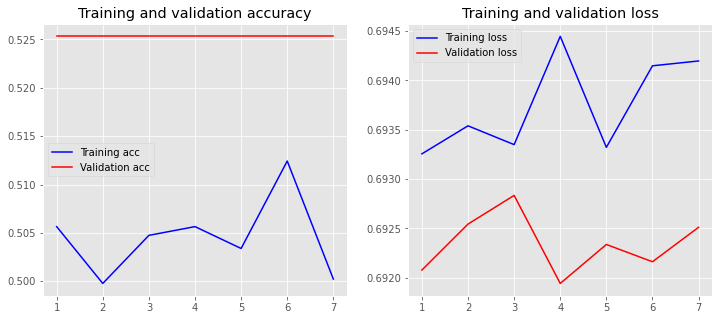

In [ ]:
plot_history(history)

In [ ]:
display_model_score(model,
     [X_train, Y_train],
     [X_test, Y_test],
     [X_test, Y_test],
     256)

9/9 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5133
Train loss:  0.6928633451461792
Train accuracy:  0.513330340385437
----------------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step - loss: 0.6925 - accuracy: 0.5253
Val loss:  0.692511260509491
Val accuracy:  0.5253164768218994
----------------------------------------------------------------------
1/1 [==============================] - 0s 22ms/step - loss: 0.6925 - accuracy: 0.5253
Test loss:  0.692511260509491
Test accuracy:  0.5253164768218994


In [ ]:
# saving model weights.
model.save_weights('/content/Extremophiles/ProtTransMLP1.h5')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [ ]:
print(classification_report(Y_test, y_pred))

### BLSTM

In [ ]:
max_length = 1024
x_input = Input(shape=(1024,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 embedding (Embedding)       (None, 1024, 128)         2688      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              99328     
 l)                                                              
                                                                 
 dropout_96 (Dropout)        (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 102,145
Trainable params: 102,145
Non-trainable params: 0
_______________________________________________________

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
history1 = model1.fit(
    X_train, Y_train,
    epochs=50, batch_size=256,
    validation_data=(X_test, Y_test),
    callbacks=[es]
    )

Epoch 1/50
9/9 [==============================] - 9s 384ms/step - loss: 6.2336 - accuracy: 0.4934 - val_loss: 5.6888 - val_accuracy: 0.5253
Epoch 2/50
9/9 [==============================] - 1s 159ms/step - loss: 5.3308 - accuracy: 0.5133 - val_loss: 4.8771 - val_accuracy: 0.5253
Epoch 3/50
9/9 [==============================] - 1s 160ms/step - loss: 4.5836 - accuracy: 0.5002 - val_loss: 4.2133 - val_accuracy: 0.5253
Epoch 4/50
9/9 [==============================] - 1s 160ms/step - loss: 3.9752 - accuracy: 0.5120 - val_loss: 3.6764 - val_accuracy: 0.5253
Epoch 5/50
9/9 [==============================] - 1s 159ms/step - loss: 3.4864 - accuracy: 0.5133 - val_loss: 3.2471 - val_accuracy: 0.5253
Epoch 6/50
9/9 [==============================] - 1s 160ms/step - loss: 3.0962 - accuracy: 0.5142 - val_loss: 2.9061 - val_accuracy: 0.5253
Epoch 7/50
9/9 [==============================] - 1s 162ms/step - loss: 2.7856 - accuracy: 0.5129 - val_loss: 2.6345 - val_accuracy: 0.5253
Epoch 8/50
9/9 [====

In [ ]:
model1.save_weights('/content/Extremophiles/ProtTransBLSTM1.h5')

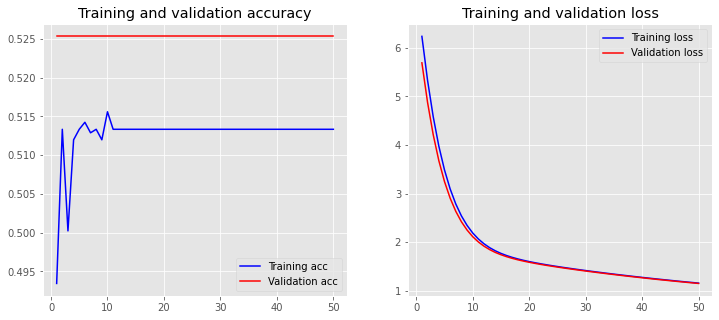

In [ ]:
plot_history(history1)

In [ ]:
display_model_score(model1,
    [X_train, Y_train],
    [X_test, Y_test],
    [X_test, Y_test],
    256)

9/9 [==============================] - 1s 59ms/step - loss: 1.1514 - accuracy: 0.5133
Train loss:  1.1513606309890747
Train accuracy:  0.513330340385437
----------------------------------------------------------------------
1/1 [==============================] - 0s 71ms/step - loss: 1.1509 - accuracy: 0.5253
Val loss:  1.1508688926696777
Val accuracy:  0.5253164768218994
----------------------------------------------------------------------
1/1 [==============================] - 0s 72ms/step - loss: 1.1509 - accuracy: 0.5253
Test loss:  1.1508688926696777
Test accuracy:  0.5253164768218994


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [ ]:
print(classification_report(Y_test, y_pred))

In [ ]:
embedding_layer = Embedding(1024, 64)

In [ ]:
max_words = 5000

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_words, 100))
model.add(layers.Bidirectional(layers.LSTM(100,dropout=0.6)))
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)

In [ ]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=70,validation_data=(X_test, Y_test))

Epoch 1/70
35/35 [==============================] - 8s 137ms/step - loss: 0.6931 - accuracy: 0.5124 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 2/70
35/35 [==============================] - 4s 111ms/step - loss: 0.6928 - accuracy: 0.5151 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 3/70
35/35 [==============================] - 4s 112ms/step - loss: 0.6932 - accuracy: 0.5061 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 4/70
35/35 [==============================] - 4s 112ms/step - loss: 0.6928 - accuracy: 0.5124 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 5/70
35/35 [==============================] - 4s 110ms/step - loss: 0.6927 - accuracy: 0.5120 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 6/70
35/35 [==============================] - 4s 111ms/step - loss: 0.6929 - accuracy: 0.5165 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 7/70
35/35 [==============================] - 4s 111ms/step - loss: 0.6928 - accuracy: 0.5093 - val_loss: 0.6925 - val_accuracy: 0.5253
Epoch 

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

In [ ]:
epoch_count = range(1, len(training_loss) + 1)

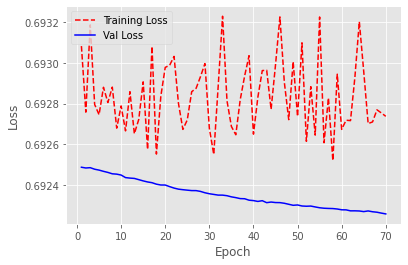

In [ ]:
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('Test accuracy:', test_acc)

5/5 [==============================] - 0s 38ms/step - loss: 0.6923 - accuracy: 0.5253
Test accuracy: 0.5253164768218994
